<a href="https://colab.research.google.com/github/markustoivonen/AIHealthTech2020/blob/master/exercises/ex7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [36]:
"""
ELEC- E8739 AI in Health Technologies D. Exercise 7
Code by Joel Jaskari, Aalto University, 2020
"""

def get_horses_zebras_dataset(batch_size = 32):
    # A quick and dirty way to make a supervised dataset from the cyclegan horses and zebras dataset:
    # A = 0 = Horses
    # B = 1 = Zebras
    # These images will be 256x256 so keep that in mind
    dataset = tfds.as_numpy(tfds.load('cycle_gan/horse2zebra',
                                    as_supervised=True,
                                    batch_size=-1))

    train_horses_images,train_horses_labels = dataset['trainA']
    train_zebras_images,train_zebras_labels = dataset['trainB']
    test_horses_images,test_horses_labels = dataset['testA']
    test_zebras_images,test_zebras_labels = dataset['testB']

    # Make numpy arrays:
    train_images = np.concatenate([train_horses_images,train_zebras_images],axis=0)
    train_labels = np.concatenate([train_horses_labels,train_zebras_labels],axis=0)
    test_images = np.concatenate([test_horses_images,test_zebras_images],axis=0)
    test_labels = np.concatenate([test_horses_labels,test_zebras_labels],axis=0)
    # Split a validation set randomly from the train images. Lets say 20% of train set is enough:
    rng = np.random.RandomState(123)
    num_train_ims = train_images.shape[0]
    new_order_train = rng.permutation(num_train_ims)
    train_images = train_images[new_order_train]
    train_labels = train_labels[new_order_train]

    # Now we have the three sets: train, validation and test
    # Lastly we can make these into tensorflow datasets:
    # Notice that the Dataset.from_tensor_slices takes an array in, in this case two as tuple so that labels and images are in same order
    # then .batch(batch_size) will set the iterator such that it returns batch_size number of elements at once
    # IMPORTANT! typically we want to shuffle the data between epochs so that no periodicity in the order of the samples appears,
    # but tensorflow does not support this for huge datasets using tf.data API. You might want to change this if you have larger dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(9999).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_labels)).shuffle(9999).batch(batch_size)

    return train_dataset,validation_dataset,test_dataset


In [37]:
train_dataset, validation_dataset, test_dataset = get_horses_zebras_dataset()

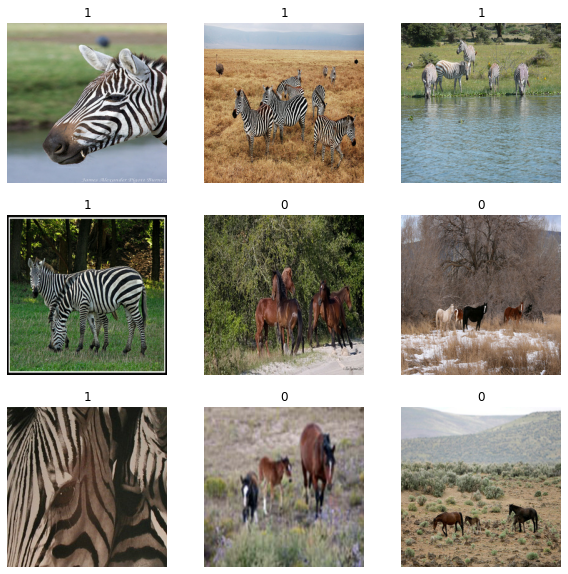

In [38]:
# Plot some images from the set
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")


In [39]:
def create_model(train_params: bool = False, weights: str = "imagenet"):
  base_model = tf.keras.applications.EfficientNetB0(input_shape=(256, 256, 3), include_top=False, weights=weights)
  base_model.trainable = train_params
  return keras.Sequential([base_model, layers.Flatten(), layers.Dense(2, name="class_score")])

def compile_model(model, base_learning_rate: float = 0.0001):
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
def fit_model(train_dataset, test_dataset, model, epochs: int = 10):
  callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,patience=5,restore_best_weights=True)
  return model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=test_dataset,
                    callbacks=[callback])
  
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


Epoch 1/20
76/76 [==============================] - 5s 71ms/step - loss: 0.7087 - accuracy: 0.7060 - val_loss: 0.2100 - val_accuracy: 0.6750
Epoch 2/20
76/76 [==============================] - 4s 55ms/step - loss: 0.1953 - accuracy: 0.6364 - val_loss: 0.3779 - val_accuracy: 0.4604
Epoch 3/20
76/76 [==============================] - 4s 55ms/step - loss: 0.1642 - accuracy: 0.3911 - val_loss: 0.0827 - val_accuracy: 0.3625
Epoch 4/20
76/76 [==============================] - 4s 55ms/step - loss: 0.0991 - accuracy: 0.3953 - val_loss: 0.0643 - val_accuracy: 0.3729
Epoch 5/20
76/76 [==============================] - 4s 55ms/step - loss: 0.0901 - accuracy: 0.4011 - val_loss: 0.0643 - val_accuracy: 0.4000
Epoch 6/20
76/76 [==============================] - 4s 56ms/step - loss: 0.0873 - accuracy: 0.4115 - val_loss: 0.0504 - val_accuracy: 0.4104
Epoch 7/20
76/76 [==============================] - 4s 56ms/step - loss: 0.0821 - accuracy: 0.4440 - val_loss: 0.0229 - val_accuracy: 0.4292
Epoch 8/20
76

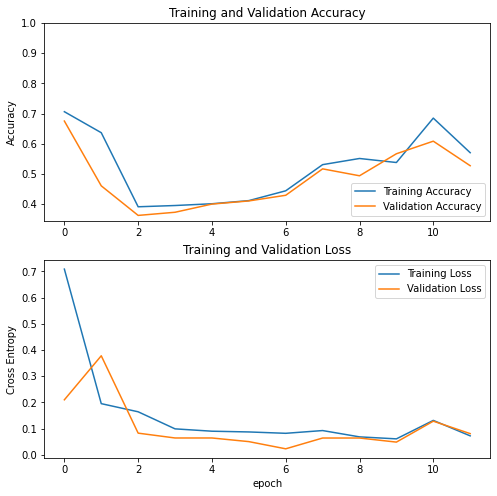

In [40]:
# Run the model with the pre-trained weights, and freeze them.
# So we only train the final layer.
train_dataset, validation_dataset, test_dataset = get_horses_zebras_dataset()
model = create_model()
compile_model(model)
history = fit_model(train_dataset, validation_dataset, model, 20)
plot_history(history)

Epoch 1/20
 2/76 [..............................] - ETA: 9s - loss: 2.6494 - accuracy: 0.4062WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0666s vs `on_train_batch_end` time: 0.1891s). Check your callbacks.


76/76 [==============================] - 22s 284ms/step - loss: 2.7609 - accuracy: 0.5369 - val_loss: 4.5923 - val_accuracy: 0.4500
Epoch 2/20
76/76 [==============================] - 20s 268ms/step - loss: 2.3013 - accuracy: 0.7110 - val_loss: 4.8141 - val_accuracy: 0.4500
Epoch 3/20
76/76 [==============================] - 20s 270ms/step - loss: 2.4572 - accuracy: 0.5839 - val_loss: 7.6729 - val_accuracy: 0.5500
Epoch 4/20
76/76 [==============================] - 20s 270ms/step - loss: 4.1120 - accuracy: 0.5314 - val_loss: 7.6282 - val_accuracy: 0.5500
Epoch 5/20
76/76 [==============================] - 20s 268ms/step - loss: 4.0473 - accuracy: 0.5294 - val_loss: 7.5069 - val_accuracy: 0.5500
Epoch 6/20
76/76 [==============================] - 21s 271ms/step - loss: 3.9778 - accuracy: 0.5173 - val_loss: 3.8651 - val_accuracy: 0.5500
Epoch 7/20
76/76 [==============================] - 21s 271ms/step - loss: 4.1593 - accuracy: 0.2907 - val_loss: 4.6910 - val_accuracy: 0.5312
Epoch 8/20

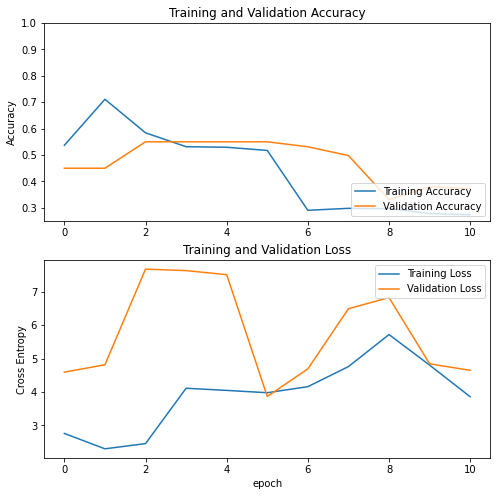

In [41]:
# Run the model with random initial weights
# So we train the whole network. 
train_dataset, validation_dataset, test_dataset = get_horses_zebras_dataset()
model = create_model(train_params=True, weights=None)
compile_model(model)
history = fit_model(train_dataset, validation_dataset, model, 20)
plot_history(history)

For both models, the performance seems to depend heavily on the individual run. However, the pretrained model nearly always performs better than the one where we random init the whole model. However, there are exceptions, and sometimes the pretrained model performs really bad (worse than guessing). 

The early stopping patience value was increased to 5, since for the pretrained model, it nearly always stopped after 3 epochs. However, still the models seem not to learn very well, especially in the case of random init weights. 

The results above were for 20 epochs (max)

## 2.1

The CycleGAN attempts to do an image-to-image translation without an actual training set of aligned image pairs. The method wants to learn the relationship of $$Y = G(X)$$ where $Y$ is the target domain, and $X$ represents the source domain. 

To improve the performance of the transformation, it uses the inverse mapping:

$$\hat{X} = F(G(X))$$

So we try to map the image back from the target domain to the source domain. In ideal situation $X=\hat{X}$. 

## 2.2

In image-to-image translation  we usually require image pairs, the source and target images. These datasets are usually hard & expensive to get. In CycleGAN the image pairs can be totally irrelevant to one another. Although we of course want the pairs to be somewhat relevant (horses & zebras, summer & winter pictures etc)

The cyclic loss has two parts, the forward cycle and backwards cycle. Basically they compute separately 

$$\hat{X} = F(G(X))$$

$$\hat{Y} = G(F(X))$$

and try to minimize the loss between the original images.

No article I read really explains why the shapes stay similar, but I guess it has to do with the fact that the cyclic loss penalizes shape deformation (L1 loss for pixels), so the generators try to keep the shapes same?


## 2.3

CycleGAN could be used to create more examples of medical images, that correspond to either sick or healthy patients. For example images of moles on the skin or brain MRI images with or without tumors.
